In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read in data
df = pd.read_table("schooldropout.csv", sep=';')

#encode Target variable as integers, with graduate = enrolled so there are 2 classes
df['Target'].replace(['Dropout', 'Graduate', 'Enrolled'], [0, 1, 1], inplace=True)

#min max scale numeric variables
def scale(column):
    return (df[column] - df[column].min()) / (df[column].max() - df[column].min())

for col in ['Previous qualification (grade)', 
                'Admission grade', 
                'Age at enrollment', 
                'Curricular units 1st sem (credited)',
                'Curricular units 1st sem (enrolled)',
                'Curricular units 1st sem (evaluations)',
                'Curricular units 1st sem (approved)',
                'Curricular units 1st sem (grade)',
                'Curricular units 1st sem (without evaluations)',
                'Curricular units 2nd sem (credited)',
                'Curricular units 2nd sem (enrolled)',
                'Curricular units 2nd sem (evaluations)',
                'Curricular units 2nd sem (approved)',
                'Curricular units 2nd sem (grade)',
                'Curricular units 2nd sem (without evaluations)',
                'Unemployment rate',
                'Inflation rate',
                'GDP'
            ]:
    df[col] = scale(col)

#split into train and test sets
trainX, testX, trainY, testY = train_test_split(df.drop('Target', axis=1), 
                                                df['Target'], test_size=0.3, random_state=0)



In [22]:
#can't visualize with 36 predictors and no useful components from FAMD
#try different kernal types, using default parameters, except dual in LinearSVC
#default dual=True is more applicable when n_samples < n_features

#linear
svmLinear = svm.SVC(kernel='linear')
fitLinear = svmLinear.fit(trainX, trainY)
testLinear = svmLinear.score(testX, testY)

#poly, degree = 3
svmSquare = svm.SVC(kernel='poly', degree=2)
fitSquare = svmSquare.fit(trainX, trainY)
testSquare = svmSquare.score(testX, testY)

#poly, degree = 3
svmCube = svm.SVC(kernel='poly', degree=3)
fitCube = svmCube.fit(trainX, trainY)
testCube = svmCube.score(testX, testY)

#radial
svmRadial = svm.SVC(kernel='rbf')
fitRadial = svmRadial.fit(trainX, trainY)
testRadial = svmRadial.score(testX, testY)

#sigmoid
svmSigmoid = svm.SVC(kernel='sigmoid')
fitSigmoid = svmSigmoid.fit(trainX, trainY)
testSigmoid = svmSigmoid.score(testX, testY)


In [23]:
print(testLinear)
print(testSquare)
print(testCube)
print(testRadial)
print(testSigmoid)


0.8350903614457831
0.677710843373494
0.677710843373494
0.677710843373494
0.6618975903614458


The linear kernel clearly produces the best accuracy, so let's tune the regularization parameter C:

In [8]:
mean_score = []
x = df.drop('Target', axis=1)
y = df['Target']

for C in [1, 10, 30, 60, 100]:    
    model = svm.SVC(kernel='linear', C=C)

    scores = cross_val_score(model, x, y, scoring='f1_macro')

    mean_score.append(np.mean(scores))

plt.plot([1,10,30,60,100], mean_score)
plt.title('Cross Validation Score per Value of C')
plt.xlabel('Value of C')
plt.ylabel('Mean F1 Score')
plt.show()

There is no difference between different values of C, so we'll keep it as C = 1 for simplicity. Now let's use recursive feature selection.

In [4]:

#train test split
trainX, testX, trainY, testY = train_test_split(df.drop('Target', axis=1), 
                                                df['Target'], test_size=0.3, random_state=0)

#perform rfe
model = svm.SVC(kernel='linear')
rfe = RFE(estimator = model)
fit = rfe.fit(trainX, trainY)
feature = pd.Series(data = fit.ranking_, index = trainX.columns)
sig_features = feature[feature==1].index 

print(sig_features)

Index(['Previous qualification (grade)', 'Admission grade', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 'Unemployment rate'],
      dtype='object')


Let's run cross validation on the model with only the selected features.

In [5]:
selected_df = df[['Previous qualification (grade)', 
                'Admission grade', 
                'Debtor',
                'Tuition fees up to date', 
                'Gender', 
                'Scholarship holder',
                'Age at enrollment', 
                'International',
                'Curricular units 1st sem (enrolled)',
                'Curricular units 1st sem (evaluations)',
                'Curricular units 1st sem (approved)',
                'Curricular units 1st sem (grade)',
                'Curricular units 1st sem (without evaluations)',
                'Curricular units 2nd sem (enrolled)',
                'Curricular units 2nd sem (evaluations)',
                'Curricular units 2nd sem (approved)',
                'Curricular units 2nd sem (grade)', 
                'Unemployment rate',
                'Target']]

selectedX = selected_df.drop('Target', axis=1)
y = selected_df['Target']

scores = cross_val_score(model, selectedX, y, scoring='f1_macro')

print(np.mean(scores))
print(np.var(scores))


0.8267094580307666
0.00010401177193716265


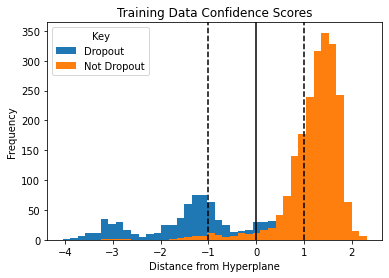

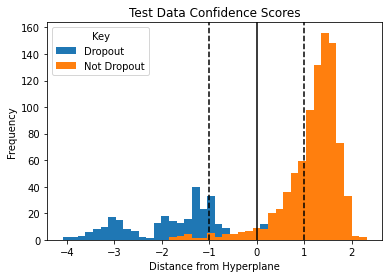

[[291 148]
 [ 42 847]]
0.8569277108433735


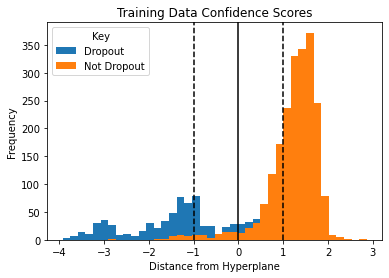

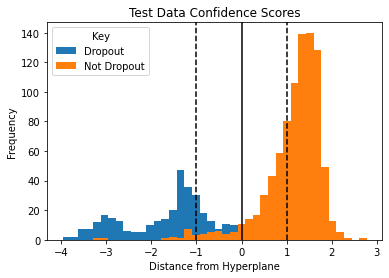

[[323 129]
 [ 46 830]]
0.8682228915662651


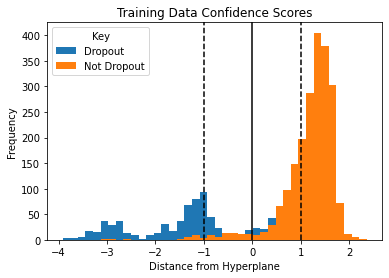

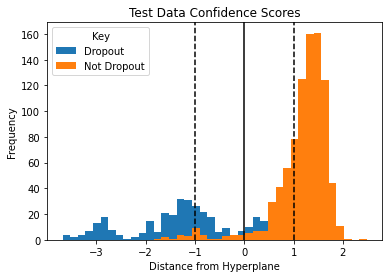

[[282 159]
 [ 37 850]]
0.8524096385542169


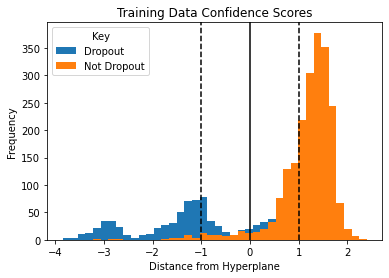

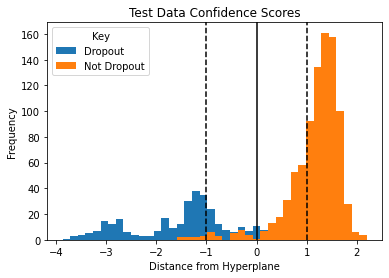

[[298 131]
 [ 35 864]]
0.875


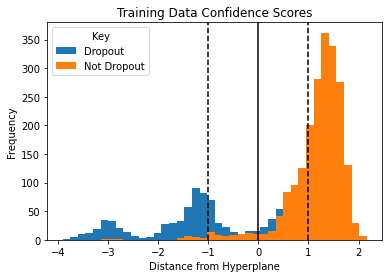

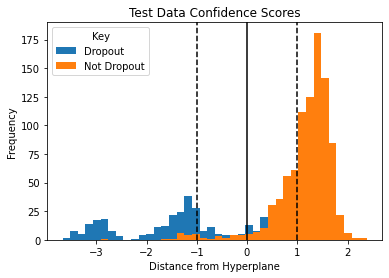

[[258 155]
 [ 36 879]]
0.8561746987951807


In [7]:
#use basic resampling to evaluate the confidence scores
#train model again with reshuffled data, 5 times

for _ in range(5):
    trainX, testX, trainY, testY = train_test_split(selected_df.drop('Target', axis=1), 
                                                    selected_df['Target'], test_size=0.3)
        
    model = svm.SVC(kernel='linear')
    model.fit(trainX, trainY)
    accuracy = model.score(testX, testY)

    #plot confidence scores of training data
    trainConfidence = pd.DataFrame(data={'Key': trainY.replace([0,1],['Dropout', 'Not Dropout']), 
                                        'Dist': model.decision_function(trainX)})
    trainConfidence.pivot(columns='Key', values='Dist').plot.hist(bins=40)
    plt.axvline(x=-1, color='k', linestyle='--')
    plt.axvline(x=1, color='k', linestyle='--')
    plt.axvline(x=0, color='k')
    plt.xlabel('Distance from Hyperplane')
    plt.title('Training Data Confidence Scores')
    plt.show()

    #plot confidence scores of test data
    testConfidence = pd.DataFrame(data={'Key': testY.replace([0,1],['Dropout', 'Not Dropout']), 
                                        'Dist': model.decision_function(testX)})
    testConfidence.pivot(columns='Key', values='Dist').plot.hist(bins=40)
    plt.axvline(x=-1, color='k', linestyle='--')
    plt.axvline(x=1, color='k', linestyle='--')
    plt.axvline(x=0, color='k')
    plt.xlabel('Distance from Hyperplane')
    plt.title('Test Data Confidence Scores')
    plt.show()

    confusion = confusion_matrix(testY, model.predict(testX))
    print(confusion)

    print(accuracy)




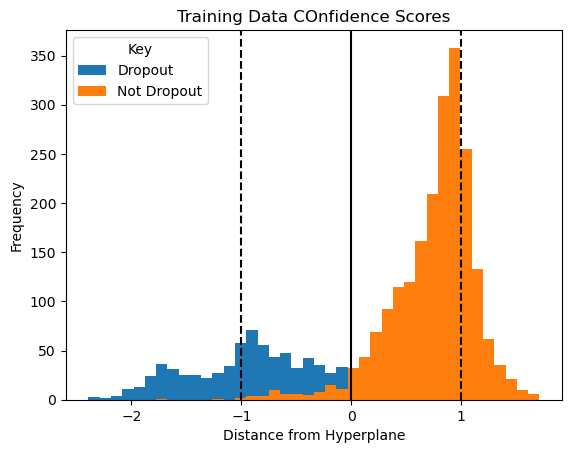

In [40]:
#plot confidence scores of training data
trainConfidence = pd.DataFrame(data={'Key': trainY.replace([0,1],['Dropout', 'Not Dropout']), 
                                     'Dist': model.decision_function(trainX)})
trainConfidence.pivot(columns='Key', values='Dist').plot.hist(bins=40)
plt.axvline(x=-1, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')
plt.axvline(x=0, color='k')
plt.xlabel('Distance from Hyperplane')
plt.title('Training Data Confidence Scores')
plt.show()

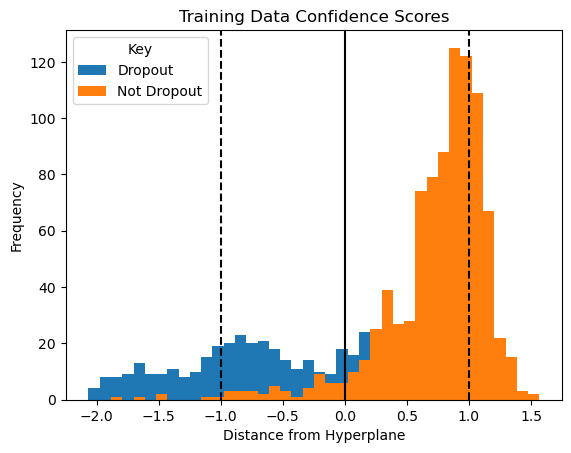

In [41]:
#plot confidence scores of testing data
testConfidence = pd.DataFrame(data={'Key': testY.replace([0,1],['Dropout', 'Not Dropout']), 
                                     'Dist': svm1.decision_function(testX)})
testConfidence.pivot(columns='Key', values='Dist').plot.hist(bins=40)
plt.axvline(x=-1, color='k', linestyle='--')
plt.axvline(x=1, color='k', linestyle='--')
plt.axvline(x=0, color='k')
plt.xlabel('Distance from Hyperplane')
plt.title('Testing Data Confidence Scores')
plt.show()